In [ ]:
#!pip install detecto

In [19]:
cd '/content/drive/My Drive/praying pals/airplane detector/'

/content/drive/My Drive/praying pals/airplane detector


In [1]:
import os
import pandas as pd
import random
import torch
import torchvision
import cv2

#from detecto.config import config
#from detecto.utils import default_transforms, filter_top_predictions, xml_to_csv, _is_iterable, read_image
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from utils import default_transforms, filter_top_p


In [71]:

import cv2
import os
import pandas as pd
import torch
import xml.etree.ElementTree as ET

from glob import glob
from torchvision import transforms
import matplotlib.patches as patches

In [3]:
import cv2

In [4]:
def xml_to_csv(xml_folder, output_file=None):

    xml_list = []
    # Loop through every XML file
    for xml_file in glob(xml_folder + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        # Each object represents each actual image label
        for member in root.findall('object'):
            box = member.find('bndbox')
            label = member.find('name').text

            # Add image file name, image size, label, and box coordinates to CSV file
            row = (filename, width, height, label, int(float(box[0].text)),
                   int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text)))
            xml_list.append(row)

    # Save as a CSV file
    column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_names)

    if output_file is not None:
        xml_df.to_csv(output_file, index=None)

    return xml_df

In [5]:
#from detecto import core, utils
from torchvision import transforms
import matplotlib.pyplot as plt

# Change data format

#xml_to_csv('train_labels/', 'train_labels.csv')
#xml_to_csv('val_labels/', 'val_labels.csv')




In [ ]:
#import core

In [6]:

class Dataset(torch.utils.data.Dataset):

    def __init__(self, label_data, image_folder=None, transform=None):

        # CSV file contains: filename, width, height, class, xmin, ymin, xmax, ymax
        if os.path.isfile(label_data):
            self._csv = pd.read_csv(label_data)
        else:
            self._csv = xml_to_csv(label_data)

        # If image folder not given, set it to labels folder
        if image_folder is None:
            self._root_dir = label_data
        else:
            self._root_dir = image_folder

        if transform is None:
            self.transform = default_transforms()
        else:
            self.transform = transform

    # Returns the length of this dataset
    def __len__(self):
        return len(self._csv)

    # Is what allows you to index the dataset, e.g. dataset[0]
    # dataset[index] returns a tuple containing the image and the targets dict
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read in the image from the file name in the 0th column
        img_name = os.path.join(self._root_dir, self._csv.iloc[idx, 0])
        image = read_image(img_name)

        # Read in xmin, ymin, xmax, and ymax
        box = self._csv.iloc[idx, 4:]
        box = torch.tensor(box).view(1, 4)

        # Read in the label
        label = self._csv.iloc[idx, 3]

        targets = {'boxes': box, 'labels': label}

        # Perform transformations
        if self.transform:
            width = self._csv.loc[idx, 'width']
            height = self._csv.loc[idx, 'height']

            # Apply the transforms manually to be able to deal with
            # transforms like Resize or RandomHorizontalFlip
            updated_transforms = []
            scale_factor = 1.0
            random_flip = 0.0
            for t in self.transform.transforms:
                # Add each transformation to our list
                updated_transforms.append(t)

                # If a resize transformation exists, scale down the coordinates
                # of the box by the same amount as the resize
                if isinstance(t, transforms.Resize):
                    original_size = min(height, width)
                    scale_factor = original_size / t.size

                # If a horizontal flip transformation exists, get its probability
                # so we can apply it manually to both the image and the boxes.
                elif isinstance(t, transforms.RandomHorizontalFlip):
                    random_flip = t.p

            # Apply each transformation manually
            for t in updated_transforms:
                # Handle the horizontal flip case, where we need to apply
                # the transformation to both the image and the box labels
                if isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < random_flip:
                        image = transforms.RandomHorizontalFlip(1)(image)
                        # Flip box's x-coordinates
                        box[0, 0] = width - box[0, 0]
                        box[0, 2] = width - box[0, 2]
                        box[0, 0], box[0, 2] = box[0, (2, 0)]
                else:
                    image = t(image)

            # Scale down box if necessary
            targets['boxes'] = (box / scale_factor).long()

        return image, targets


In [7]:

custom_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.ColorJitter(saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = Dataset('/content/drive/My Drive/praying pals/airplane detector/train_labels2.csv',
                       '/content/drive/My Drive/praying pals/airplane detector/trainimages',
                       transform=custom_transforms)

# Validation dataset

val_dataset = Dataset('/content/drive/My Drive/praying pals/airplane detector/val_labels2.csv', 
                           '/content/drive/My Drive/praying pals/airplane detector/trainimages',
                           transform=custom_transforms)

# Customize training options


In [8]:

class DataLoader(torch.utils.data.DataLoader):

    def __init__(self, dataset, **kwargs):

        super().__init__(dataset, collate_fn=DataLoader.collate_data, **kwargs)

    # Converts a list of tuples into a tuple of lists so that
    # it can properly be fed to the model for training
    @staticmethod
    def collate_data(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

In [9]:

loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [16]:
#core
config = {
    'default_device': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'default_classes': [
        'plane'
    ]
}


In [54]:
def _is_iterable(variable):
    return isinstance(variable, list) or isinstance(variable, tuple)

In [58]:
def normalize_transform():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [55]:
class Model:

    def __init__(self, classes=None, device=None):
        """Initializes a machine learning model for object detection.
        Models are built on top of PyTorch's `pre-trained models
        <https://pytorch.org/docs/stable/torchvision/models.html>`_,
        specifically the Faster R-CNN ResNet-50 FPN, but allow for
        fine-tuning to predict on custom classes/labels.

        :param classes: (Optional) A list of classes/labels for the model
            to predict. If none given, uses the default classes specified
            `here <https://pytorch.org/docs/stable/torchvision/models.html
            #object-detection-instance-segmentation-and-person-keypoint-detection>`_.
            Defaults to None.
        :type classes: list or None
        :param device: (Optional) The device on which to run the model,
            such as the CPU or GPU. See `here
            <https://pytorch.org/docs/stable/tensor_attributes.html#torch-device>`_
            for details on specifying the device. Defaults to the GPU if
            available and the CPU if not.
        :type device: torch.device or None

        **Example**::

            >>> from detecto.core import Model

            >>> model = Model(['dog', 'cat', 'bunny'])
        """

        self._device = device if device else config['default_device']

        # Load a model pre-trained on COCO
        self._model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        if classes:
            # Get the number of input features for the classifier
            in_features = self._model.roi_heads.box_predictor.cls_score.in_features
            # Replace the pre-trained head with a new one (note: +1 because of the __background__ class)
            self._model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes) + 1)
            self._disable_normalize = False
        else:
            classes = config['default_classes']
            self._disable_normalize = True

        self._model.to(self._device)

        # Mappings to convert from string labels to ints and vice versa
        self._classes = ['__background__'] + classes
        self._int_mapping = {label: index for index, label in enumerate(self._classes)}

    def _is_iterable(variable):
        return isinstance(variable, list) or isinstance(variable, tuple)


    # Returns the raw predictions from feeding an image or list of images into the model
    def _get_raw_predictions(self, images):
        self._model.eval()

        with torch.no_grad():
            # Convert image into a list of length 1 if not already a list
            if not _is_iterable(images):
                images = [images]

            # Convert to tensor and normalize if not already
            if not isinstance(images[0], torch.Tensor):
                # This is a temporary workaround to the bad accuracy
                # when normalizing on default weights. Will need to
                # investigate further TODO
                if self._disable_normalize:
                    defaults = transforms.Compose([transforms.ToTensor()])
                else:
                    defaults = default_transforms()
                images = [defaults(img) for img in images]

            # Send images to the specified device
            images = [img.to(self._device) for img in images]

            preds = self._model(images)
            # Send predictions to CPU if not already
            preds = [{k: v.to(torch.device('cpu')) for k, v in p.items()} for p in preds]
            return preds

    def predict(self, images):
        # Convert all to lists but keep track if a single image was given
        is_single_image = not _is_iterable(images)
        images = [images] if is_single_image else images
        preds = self._get_raw_predictions(images)

        results = []
        for pred in preds:
            # Convert predicted ints into their corresponding string labels
            result = ([self._classes[val] for val in pred['labels']], pred['boxes'], pred['scores'])
            results.append(result)

        return results[0] if is_single_image else results

    def predict_top(self, images):
        predictions = self.predict(images)

        # If tuple but not list, then images is a single image
        if not isinstance(predictions, list):
            return filter_top_predictions(*predictions)

        results = []
        for pred in predictions:
            results.append(filter_top_predictions(*pred))

        return results

    def fit(self, dataset, val_dataset=None, epochs=10, learning_rate=0.005, momentum=0.9,
            weight_decay=0.0005, gamma=0.1, lr_step_size=3, verbose=False):

        # If doing custom training, the given images will most likely be
        # normalized. This should fix the issue of poor performance on
        # default classes when normalizing, so resume normalizing. TODO
        if epochs > 0:
            self._disable_normalize = False

        # Convert dataset to data loader if not already
        if not isinstance(dataset, DataLoader):
            dataset = DataLoader(dataset, shuffle=True)

        if val_dataset is not None and not isinstance(val_dataset, DataLoader):
            val_dataset = DataLoader(val_dataset)

        losses = []
        # Get parameters that have grad turned on (i.e. parameters that should be trained)
        parameters = [p for p in self._model.parameters() if p.requires_grad]
        # Create an optimizer that uses SGD (stochastic gradient descent) to train the parameters
        
        print("optimizer is Adam")
        optimizer = torch.optim.Adam(parameters, lr =learning_rate)
        #optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        # Create a learning rate scheduler that decreases learning rate by gamma every lr_step_size epochs
        
        #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

        # Train on the entire dataset for the specified number of times (epochs)
        for epoch in range(epochs):
            if verbose:
                print('Epoch {} of {}'.format(epoch + 1, epochs))

            # Training step
            self._model.train()
            for images, targets in dataset:
                self._convert_to_int_labels(targets)
                images, targets = self._to_device(images, targets)

                # Calculate the model's loss (i.e. how well it does on the current
                # image and target, with a lower loss being better)
                loss_dict = self._model(images, targets)
                total_loss = sum(loss for loss in loss_dict.values())

                # Zero any old/existing gradients on the model's parameters
                optimizer.zero_grad()
                # Compute gradients for each parameter based on the current loss calculation
                total_loss.backward()
                # Update model parameters from gradients: param -= learning_rate * param.grad
                optimizer.step()

            # Validation step
            if val_dataset is not None:
                avg_loss = 0
                with torch.no_grad():
                    for images, targets in val_dataset:
                        self._convert_to_int_labels(targets)
                        images, targets = self._to_device(images, targets)
                        loss_dict = self._model(images, targets)
                        total_loss = sum(loss for loss in loss_dict.values())
                        avg_loss += total_loss.item()

                avg_loss /= len(val_dataset.dataset)
                losses.append(avg_loss)

                if verbose:
                    print('Loss: {}'.format(avg_loss))

            # Update the learning rate every few epochs
            #lr_scheduler.step()

        if len(losses) > 0:
            return losses

    def get_internal_model(self):
        return self._model

    def save(self, file):
        torch.save(self._model.state_dict(), file)

    @staticmethod
    def load(file, classes):
        model = Model(classes)
        model._model.load_state_dict(torch.load(file, map_location=model._device))
        return model

    def _convert_to_int_labels(self, targets):
        for target in targets:
            target['labels'] = torch.tensor(self._int_mapping[target['labels']]).view(1)

    def _to_device(self, images, targets):
        images = [image.to(self._device) for image in images]
        targets = [{k: v.to(self._device) for k, v in t.items()} for t in targets]
        return images, targets



In [12]:
type(loader)

__main__.DataLoader

In [21]:

def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def default_transforms():
    return transforms.Compose([transforms.ToTensor(), normalize_transform()])


def filter_top_p(labels, boxes, scores):
    filtered_labels = []
    filtered_boxes = []
    filtered_scores = []

    for label in set(labels):
        index = labels.index(label)
        filtered_labels.append(label)
        filtered_boxes.append(boxes[index])
        filtered_scores.append(scores[index])

    if len(filtered_labels) == 0:
        return filtered_labels, torch.empty(0, 4), torch.tensor(filtered_scores)
    return filtered_labels, torch.stack(filtered_boxes), torch.tensor(filtered_scores)


In [42]:

model = Model(['plane'])
#model = Model(['plane'])

optimizer is Adam
Epoch 1 of 20


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Loss: 0.17789209857583047
Epoch 2 of 20
Loss: 0.14327079678575197
Epoch 3 of 20
Loss: 0.13284855633974074
Epoch 4 of 20
Loss: 0.11790869943797588
Epoch 5 of 20
Loss: 0.10946646630764008
Epoch 6 of 20
Loss: 0.11532764670749505
Epoch 7 of 20
Loss: 0.10967044159770012
Epoch 8 of 20
Loss: 0.10320077513655027
Epoch 9 of 20
Loss: 0.10608817711472511
Epoch 10 of 20
Loss: 0.10056494648257891
Epoch 11 of 20
Loss: 0.10576862171292305
Epoch 12 of 20
Loss: 0.09731758584578833
Epoch 13 of 20
Loss: 0.09419651540617148
Epoch 14 of 20
Loss: 0.09321013937393824
Epoch 15 of 20
Loss: 0.0963840422530969
Epoch 16 of 20
Loss: 0.10152157358825206
Epoch 17 of 20
Loss: 0.08858656330655018
Epoch 18 of 20
Loss: 0.09239900764077902
Epoch 19 of 20
Loss: 0.09262184333056211
Epoch 20 of 20
Loss: 0.09330482445657254


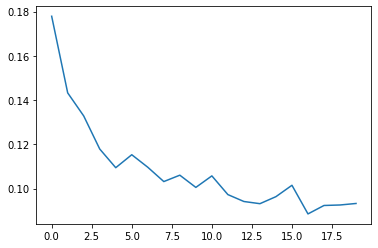

<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [22]:

#losses = model.fit(loader, val_dataset, epochs=15,
               #    learning_rate=0.0001, verbose=True)

losses = model.fit(loader, val_dataset, epochs=20, learning_rate = .0001, verbose=True)
# Visualize loss during training

plt.plot(losses)
plt.show()

# Save model

model.save('model_weights44.pt')

# Access underlying torchvision model for further control

torch_model = model.get_internal_model()
print(type(torch_model))

In [ ]:
#plot prediction image image

In [43]:
PATH = 'model_weights3.pt'

In [61]:
#predict
model = Model.load(PATH,['plane'])

In [75]:
imagePath = '/content/drive/My Drive/praying pals/airplane detector/planesTest.jpg'

In [76]:
image = read_image(imagePath)

In [77]:
 preds = model.predict(image)

In [78]:
preds

(['plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'plane'],
 tensor([[461.3710, 128.2034, 541.5856, 178.7225],
         [171.9823, 194.1547, 252.6590, 245.0256],
         [264.3579, 138.9523, 341.6546, 191.2180],
         [ 92.9983, 228.7967, 176.6473, 276.3156],
         [534.1081, 168.2081, 616.4102, 222.2367],
         [  7.7441, 184.7697,  87.9878, 233.8137],
         [463.2446, 216.7617, 548.2172, 267.5139],
         [172.9966,  80.1398, 250.9952, 132.1873],
         [340.2808,  73.7252, 418.4594, 127.2151],
         [253.3658,  45.2432, 331.8053, 100.3070],
         [ 90.2484, 144.6097, 166.4336, 197.6858],
         [381.1389, 173.6759, 467.7670, 226.8399]]),
 tensor([0.7553, 0.7486, 0.7419, 0.6679, 0.6499, 0.6383, 0.6200, 0.6188, 0.6083,
         0.5980, 0.5892, 0.5828]))

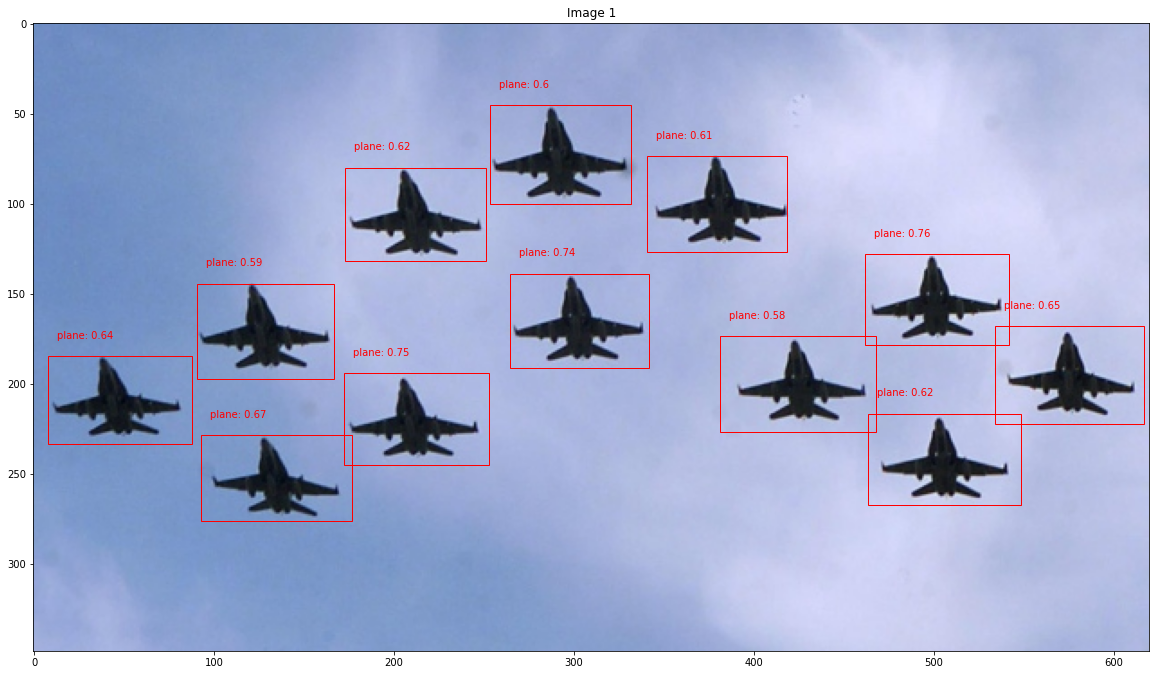

In [79]:
fig, axes = plt.subplots(1, 1, figsize=[20,20])

preds = model.predict(image)
score_filter = 0.5

# If already a tensor, reverse normalize it and turn it back
if isinstance(image, torch.Tensor):
    image = transforms.ToPILImage()(reverse_normalize(image))

axes.imshow(image)

# Plot boxes and labels
for label, box, score in zip(*preds):

    if score >= score_filter:
        width, height = box[2] - box[0], box[3] - box[1]
        initial_pos = (box[0], box[1])
        rect = patches.Rectangle(initial_pos, width, height, linewidth=1,
                                    edgecolor='r', facecolor='none')
        axes.add_patch(rect)

        axes.text(box[0] + 5, box[1] - 10, '{}: {}'
                .format(label, round(score.item(), 2)), color='red')
    axes.set_title('Image {}'.format(1))

plt.show()

In [ ]:
#utils

def default_transforms():
    return transforms.Compose([transforms.ToTensor(), normalize_transform()])


def filter_top_predictions(labels, boxes, scores):
    filtered_labels = []
    filtered_boxes = []
    filtered_scores = []
    # Loop through each unique label
    for label in set(labels):
        # Get first index of label, which is also its highest scoring occurrence
        index = labels.index(label)

        filtered_labels.append(label)
        filtered_boxes.append(boxes[index])
        filtered_scores.append(scores[index])

    if len(filtered_labels) == 0:
        return filtered_labels, torch.empty(0, 4), torch.tensor(filtered_scores)
    return filtered_labels, torch.stack(filtered_boxes), torch.tensor(filtered_scores)


def normalize_transform():
    # Default for PyTorch's pre-trained models
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def read_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def reverse_normalize(image):
    reverse = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.255],
                                   std=[1 / 0.229, 1 / 0.224, 1 / 0.255])
    return reverse(image)


# Checks whether a variable is a list or tuple only
def _is_iterable(variable):
    return isinstance(variable, list) or isinstance(variable, tuple)



In [ ]:
#import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch

from utils import reverse_normalize, normalize_transform, _is_iterable
from torchvision import transforms



def plot_prediction_grid(model, images, dim=None, figsize=None, score_filter=0.6):

    # If not specified, show all in one column
    if dim is None:
        dim = (len(images), 1)

    if dim[0] * dim[1] != len(images):
        raise ValueError('Grid dimensions do not match size of list of images')

    fig, axes = plt.subplots(dim[0], dim[1], figsize=figsize)

    # Loop through each image and position in the grid
    index = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            image = images[index]
            preds = model.predict(image)

            # If already a tensor, reverse normalize it and turn it back
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(reverse_normalize(image))
            index += 1

            # Get the correct axis
            if dim[0] <= 1 and dim[1] <= 1:
                ax = axes
            elif dim[0] <= 1:
                ax = axes[j]
            elif dim[1] <= 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            ax.imshow(image)

            # Plot boxes and labels
            for label, box, score in zip(*preds):
                if score >= score_filter:
                    width, height = box[2] - box[0], box[3] - box[1]
                    initial_pos = (box[0], box[1])
                    rect = patches.Rectangle(initial_pos, width, height, linewidth=1,
                                             edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

                    ax.text(box[0] + 5, box[1] - 10, '{}: {}'
                            .format(label, round(score.item(), 2)), color='red')
                ax.set_title('Image {}'.format(index))

    plt.show()


def show_labeled_image(image, boxes, labels=None):

    fig, ax = plt.subplots(1)
    # If the image is already a tensor, convert it back to a PILImage
    # and reverse normalize it
    if isinstance(image, torch.Tensor):
        image = reverse_normalize(image)
        image = transforms.ToPILImage()(image)
    ax.imshow(image)

    # Show a single box or multiple if provided
    if boxes.ndim == 1:
        boxes = boxes.view(1, 4)

    if labels is not None and not _is_iterable(labels):
        labels = [labels]

    # Plot each box
    for i in range(boxes.shape[0]):
        box = boxes[i]
        width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
        initial_pos = (box[0].item(), box[1].item())
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                 edgecolor='r', facecolor='none')
        if labels:
            ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='red')

        ax.add_patch(rect)

    plt.show()

